In [1]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms, models
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
import  random as rand
import torch.utils.data
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as nnfun
import GPUtil
GPUtil.showUtilization()

print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

torch.manual_seed(42)

| ID | GPU | MEM |
------------------
|  0 | 22% | 23% |
0
0


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


Running on the GPU


In [3]:
class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [4]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [21]:
data = ImageFolder(root='/ssd_data/MTG Land/')

n = len(data)
n_test = int(len(data) * .1)
n_train = n - 2 * n_test

train_data,validation_data, test_data = torch.utils.data.random_split(data, (n_train, n_test, n_test))
validation_data = ApplyTransform(validation_data, transform=transform_test)
test_data = ApplyTransform(test_data, transform=transform_test)

GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  1% | 74% |


In [6]:
training_loader = torch.utils.data.DataLoader(train_data, batch_size=40, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=52, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=52, shuffle=False)




In [7]:
model = (torch.load("outputs/full_model_VG13_Final"))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)
class_labels =  data.classes

In [8]:
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []


with torch.no_grad():
    model.eval()
    torch.cuda.empty_cache()
    running_loss = 0.0
    running_corrects = 0.0

    val_running_loss = 0.0
    val_running_correct = 0.0


    for val_inputs, val_labels in test_loader:
        val_inputs = val_inputs
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        #1, 28, 28
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_correct += torch.sum(val_preds == val_labels.data)

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_accuracy = val_running_correct.float() / len(validation_loader.dataset)

    val_running_loss_history.append(val_epoch_loss)
    val_running_correct_history.append(val_epoch_accuracy)


    print('testing loss: {:.4f}, {:.4f}'.format(val_epoch_loss, val_epoch_accuracy.item()))


testing loss: 0.0225, 0.8302


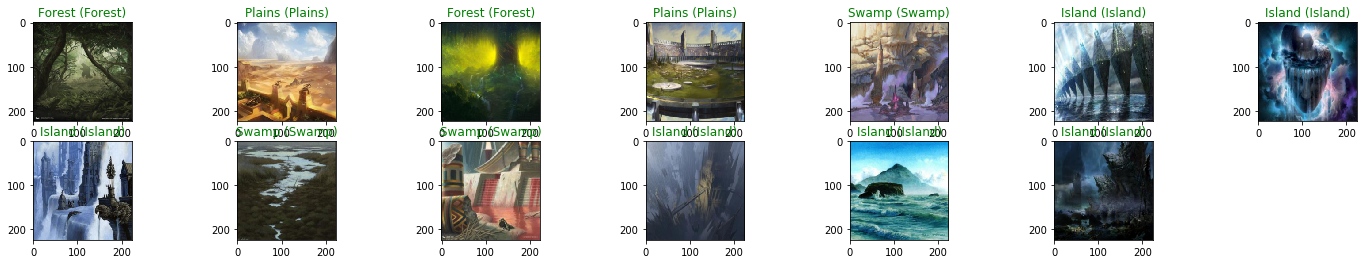

In [9]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=13, shuffle=False)
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(13):
        ax = fig.add_subplot(2, 7, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))

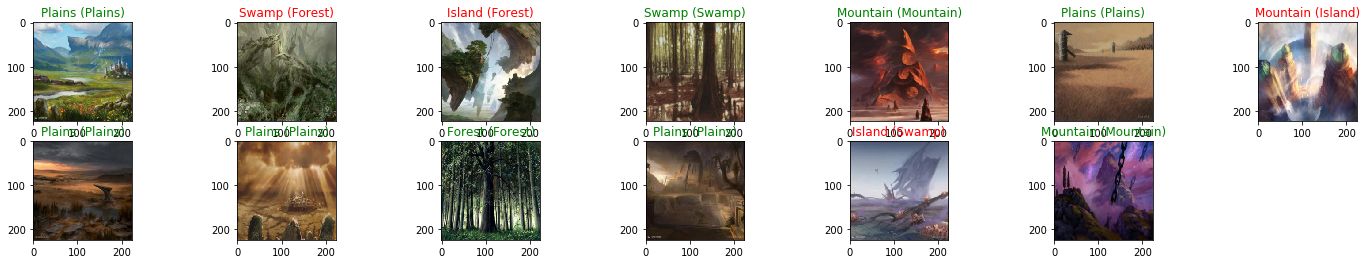

In [10]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(13):
        ax = fig.add_subplot(2, 7, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))

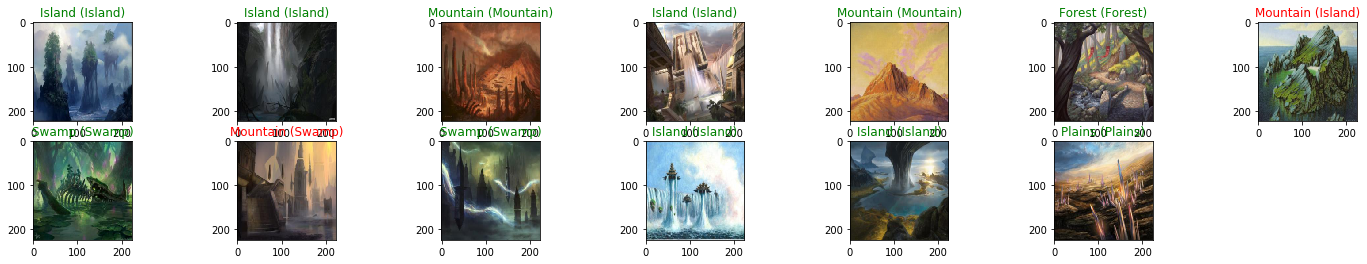

In [11]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(13):
        ax = fig.add_subplot(2, 7, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))



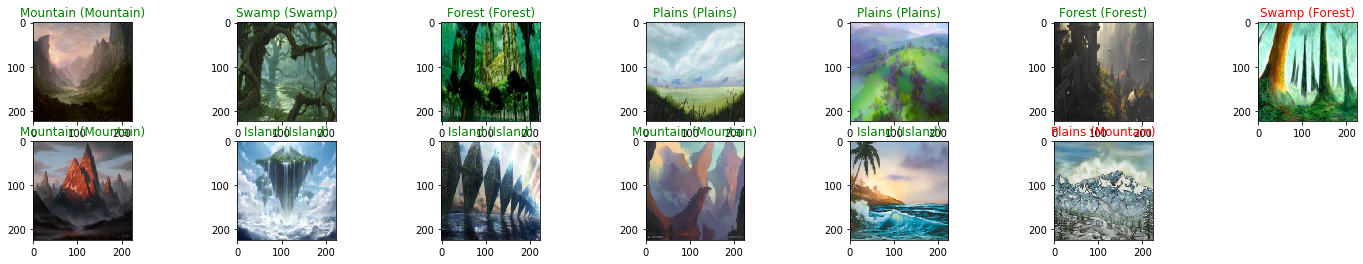

In [12]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(13):
        ax = fig.add_subplot(2, 7, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))


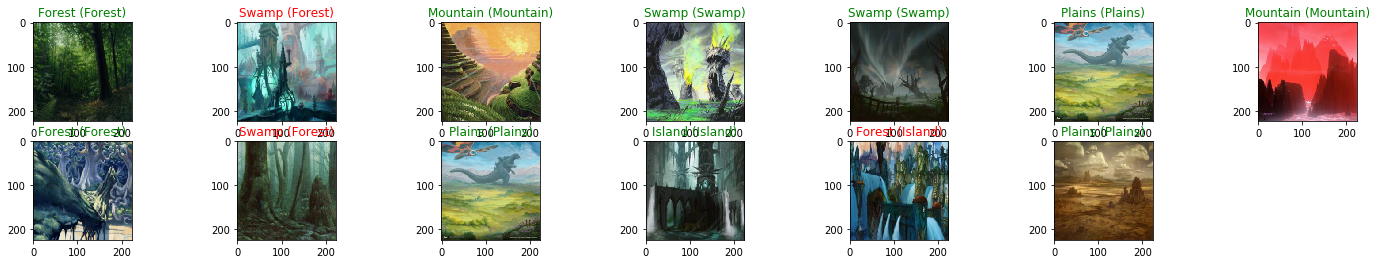

In [13]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(13):
        ax = fig.add_subplot(2, 7, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))



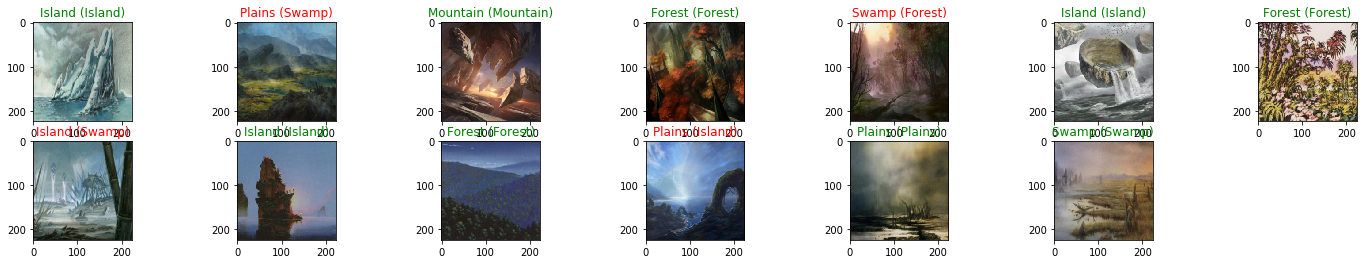

In [14]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(13):
        ax = fig.add_subplot(2, 7, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))


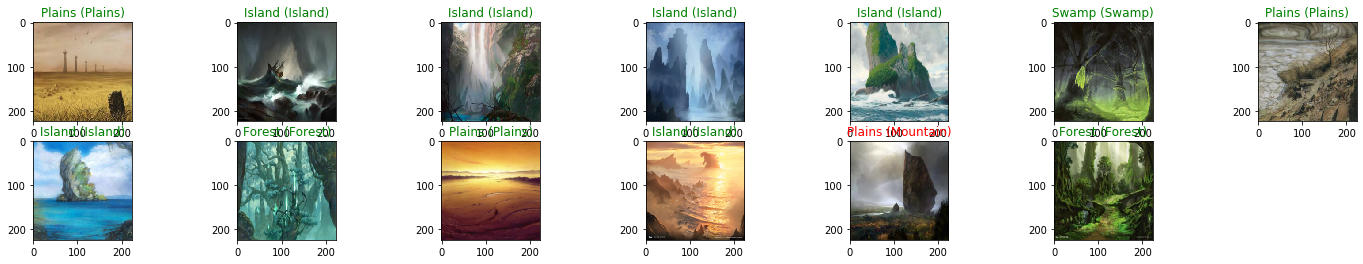

In [15]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(13):
        ax = fig.add_subplot(2, 7, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))


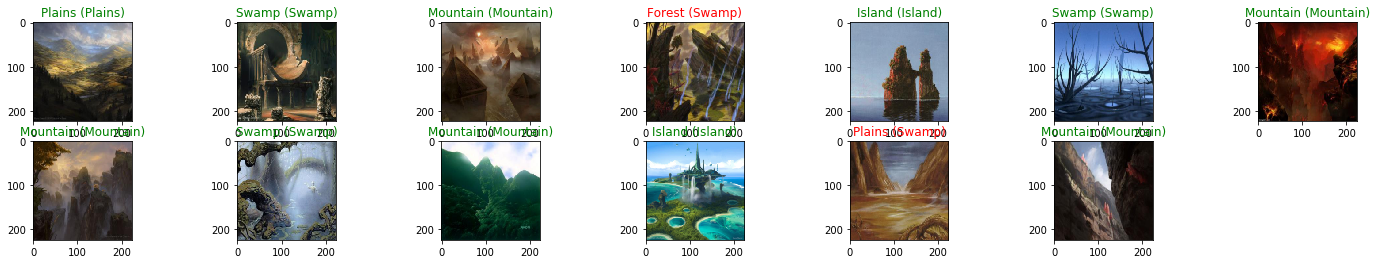

In [16]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)
    fig = plt.figure(figsize=(25, 4))

    for index in np.arange(13):
        ax = fig.add_subplot(2, 7, index+1)
        plt.imshow(im_convert(images[index]))
        ax.set_title("{} ({})".format(class_labels[preds[index].item()], class_labels[labels[index].item()]), color = ("green" if preds[index] == labels[index] else "red"))




In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

plains = [0, 0, 0, 0, 0]
island = [0, 0, 0, 0, 0]
swamp = [0, 0, 0, 0, 0]
mountain = [0, 0, 0, 0, 0]
forest = [0, 0, 0, 0, 0]


test_loader = torch.utils.data.DataLoader(test_data, batch_size=104, shuffle=False)
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    gpu_images = images
    gpu_images = gpu_images.to(device)
    output = model(gpu_images)

    _, preds = torch.max(output, 1)

    actual = []
    prediction = []

    for i in range(len(labels)):
        if labels[i] == 0:
            actual.append("Forest")
        elif labels[i] == 1:
            actual.append("Island")
        elif labels[i] == 2:
            actual.append("Mountain")
        elif labels[i] == 3:
            actual.append("Plains")
        else:
            actual.append("Swamp")

    for x in range(len(preds)):
        if preds[x] == 0:
            prediction.append("Forest")
        elif preds[x] == 1:
            prediction.append("Island")
        elif preds[x] == 2:
            prediction.append("Mountain")
        elif preds[x] == 3:
            prediction.append("Plains")
        else:
            prediction.append("Swamp")

    matrix = confusion_matrix(actual,prediction, labels=class_labels)
    print('Confusion matrix : \n',matrix)

    # outcome values order in sklearn
    #forest_tp, forest_fn, forest_fp, tn = confusion_matrix(actual,prediction,labels=class_labels).reshape(-1)
    #print('Outcome values : \n', tp, fn, fp, tn)

    # classification report for precision, recall f1-score and accuracy
    matrix = classification_report(actual,prediction,class_labels)
    print('Classification report : \n',matrix)

Confusion matrix : 
 [[13  1  0  0  5]
 [ 1 26  2  1  0]
 [ 0  0 15  2  0]
 [ 0  0  0 18  0]
 [ 1  2  1  2 14]]
Classification report : 
               precision    recall  f1-score   support

      Forest       0.87      0.68      0.76        19
      Island       0.90      0.87      0.88        30
    Mountain       0.83      0.88      0.86        17
      Plains       0.78      1.00      0.88        18
       Swamp       0.74      0.70      0.72        20

    accuracy                           0.83       104
   macro avg       0.82      0.83      0.82       104
weighted avg       0.83      0.83      0.82       104



TypeError: Image data of dtype <U488 cannot be converted to float

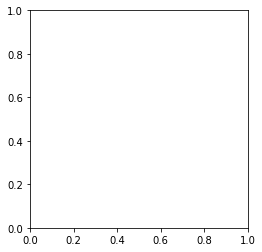

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + class_labels)
ax.set_yticklabels([''] + class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
 